## Setup

In [15]:
import torch
import numpy as np

import torchvision
from torch.utils.data import DataLoader, Subset
from torch.backends import mps
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn 
from net_covid19 import Covid19Net
from net_a import ANET
import time
from sklearn.metrics import precision_score, recall_score, fbeta_score,confusion_matrix
import seaborn as sns
from sklearn.model_selection import KFold
import mlflow
import mlflow.pytorch

def imshow(img, title=None):
  ''' function to show image '''
  plt.imshow(img.permute(1, 2, 0))
  if title is not None:
    plt.title(title)
  plt.show()

# setup some path variables
project_path = './'
data_path = project_path + 'data/Pneumonia/X-Ray/'
data_path = project_path + 'data/Pneumonia/X-Ray_70-30/'

# select device to run the computations on
if mps.is_available(): # MAcOS with Metal support
    device = torch.device('mps')
elif torch.cuda.is_available(): # Nvidia GPU
    device = torch.device('cuda')
else: # CPU
    device = torch.device('cpu')

# device = torch.device('cpu') # uncomment this line to run on CPU
print(20*"#")
print("Device used: ", device)
print(20*"#")

####################
Device used:  cuda
####################


Preprocess Data

In [4]:

# Define the transformations
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),  # Resize the image to 224x224
    torchvision.transforms.ToTensor() # Convert the image to a pytorch tensor
])

# Define train / test dataset
train_dataset = torchvision.datasets.ImageFolder(data_path + 'train/', transform=image_transform)
test_dataset = torchvision.datasets.ImageFolder(data_path + 'test/', transform=image_transform)

# Check the classes labels
class_labels = train_dataset.classes
print(class_labels)

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)


# Check the number of samples in the train and test dataset
print('Number of images in train set:', len(train_dataset))
print('Number of images in test set:', len(test_dataset))

# sample_idx = 240
# sample_image, sample_label = train_dataset[sample_idx]
# print(f'Image Shape: {sample_image.shape}')
# print(f'Label: {class_labels[sample_label]}')

# imshow(sample_image)
# sample_image[0,:,:]

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# get a batch of images and labels
images, labels = next(iter(train_loader))
print(f'Shape of image tensors: {images.shape}')
print(f'Shape of label tensors: {labels.shape}')

# Display the batch of images
class_labels_string = ', '.join([class_labels[label] for label in labels]) # Create a string of class labels indexed by labels
# imshow(torchvision.utils.make_grid(images), title = class_labels_string)
# plt.title(class_labels_string)

print(class_labels_string)
print([class_labels[label] for label in labels])
print(images)

['Bacterial', 'Viral']
Number of images in train set: 11318
Number of images in test set: 4849
Shape of image tensors: torch.Size([16, 3, 224, 224])
Shape of label tensors: torch.Size([16])
Bacterial, Bacterial, Viral, Bacterial, Viral, Bacterial, Viral, Bacterial, Bacterial, Bacterial, Bacterial, Bacterial, Bacterial, Viral, Bacterial, Bacterial
['Bacterial', 'Bacterial', 'Viral', 'Bacterial', 'Viral', 'Bacterial', 'Viral', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Bacterial', 'Viral', 'Bacterial', 'Bacterial']
tensor([[[[0.3725, 0.3686, 0.3608,  ..., 0.0667, 0.0588, 0.0431],
          [0.3569, 0.3843, 0.3608,  ..., 0.0510, 0.0431, 0.0510],
          [0.3608, 0.4039, 0.4078,  ..., 0.2471, 0.0902, 0.0353],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0941, 0.0510, 0.0039],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.3725, 0.3686, 0.3608,  ..., 0.06

### Get Class weight for weighted loss

In [5]:
# Calculate class weights efficiently using numpy
train_labels = np.array([label for _, label in train_dataset])
class_counts = np.bincount(train_labels)
total_samples = len(train_dataset)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a tensor and move to the appropriate device
class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(class_labels))]).to(device)
class_weights_tensor = torch.tensor(class_weights_tensor, dtype=torch.float32).to(device)  # Ensure dtype is float32
print("Class weights tensor:", class_weights_tensor)

Class weights tensor: tensor([0.8127, 1.2994], device='cuda:0')


C:\Users\chusa\AppData\Local\Temp\ipykernel_20892\598590694.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights_tensor, dtype=torch.float32).to(device)  # Ensure dtype is float32


## Define the model

In [4]:

net = Covid19Net()
# net = ANET()
print(net)

net.to(device)


Covid19Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)


Covid19Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=93312, out_features=2, bias=True)
)

## Train the model

In [5]:

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

num_epochs = 40 # loop over the dataset multiple times

e_ = np.arange(1,num_epochs+1,1)
loss_ = []

start_time = time.time()
for epoch in range(num_epochs): # one epoch is a complete pass through the train dataset
    epoch_loss = 0.0
    for batch_index, data in enumerate(train_loader):
        images, labels = data 
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = net(images)
        # outputs = outputs[:,0]
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_.append(epoch_loss)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}') # print the loss every epoch

end_time = time.time()
execution_time = end_time - start_time
print(f"Training completed in {execution_time} seconds")

torch.save(net.state_dict(), project_path + 'covid19_net_40epo.pth')


# torch.save(net.state_dict(), project_path + 'a_net.pth')

Epoch: 0, Loss: 423.6697785407305
Epoch: 1, Loss: 373.76703202724457
Epoch: 2, Loss: 341.87715819478035
Epoch: 3, Loss: 303.5784719064832
Epoch: 4, Loss: 256.7988358438015
Epoch: 5, Loss: 209.23542170226574
Epoch: 6, Loss: 159.82486318983138
Epoch: 7, Loss: 111.37911854311824
Epoch: 8, Loss: 80.11132107581943
Epoch: 9, Loss: 50.40053292969242
Epoch: 10, Loss: 38.48751198116224
Epoch: 11, Loss: 27.090395510487724
Epoch: 12, Loss: 8.193920064499252
Epoch: 13, Loss: 2.9178092722686415
Epoch: 14, Loss: 1.8137740622696583
Epoch: 15, Loss: 1.3805939997473615
Epoch: 16, Loss: 1.0993669807576225
Epoch: 17, Loss: 0.9231861568696331
Epoch: 18, Loss: 0.780439033980656
Epoch: 19, Loss: 0.6855676542618312
Epoch: 20, Loss: 0.6077172204441013
Epoch: 21, Loss: 0.536976559968025
Epoch: 22, Loss: 0.48478886044586034
Epoch: 23, Loss: 0.44107106691262743
Epoch: 24, Loss: 0.4053264294616383
Epoch: 25, Loss: 0.37263883600826375
Epoch: 26, Loss: 0.3488754374320706
Epoch: 27, Loss: 0.32147907808757736
Epoch: 

## Train with class weight loss

In [33]:

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

num_epochs = 40 # loop over the dataset multiple times

e_ = np.arange(1,num_epochs+1,1)
loss_ = []

start_time = time.time()
for epoch in range(num_epochs): # one epoch is a complete pass through the train dataset
    epoch_loss = 0.0
    for batch_index, data in enumerate(train_loader):
        images, labels = data 
        images, labels = images.to(device), labels.to(device)


        optimizer.zero_grad()
        outputs = net(images)
        # outputs = outputs[:,0]
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    loss_.append(epoch_loss)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}') # print the loss every epoch

end_time = time.time()
execution_time = end_time - start_time
print(f"Training completed in {execution_time} seconds")

# torch.save(net.state_dict(), project_path + 'covid19_net.pth')


torch.save(net.state_dict(), project_path + 'covid19_weighted.pth')

Epoch: 0, Loss: 420.11361587047577
Epoch: 1, Loss: 373.42046447098255
Epoch: 2, Loss: 334.3868741542101
Epoch: 3, Loss: 288.4445787295699
Epoch: 4, Loss: 242.8110836595297
Epoch: 5, Loss: 193.25831108540297
Epoch: 6, Loss: 143.00514284335077
Epoch: 7, Loss: 115.86999323405325
Epoch: 8, Loss: 74.15135920839384
Epoch: 9, Loss: 53.30016302195145
Epoch: 10, Loss: 34.71960723598022
Epoch: 11, Loss: 25.4652046856354
Epoch: 12, Loss: 22.41985342522821
Epoch: 13, Loss: 8.674598716737819
Epoch: 14, Loss: 2.027902453788556
Epoch: 15, Loss: 1.2496602726459969
Epoch: 16, Loss: 0.9574542747132
Epoch: 17, Loss: 0.7740075376059394
Epoch: 18, Loss: 0.6636673571592837
Epoch: 19, Loss: 0.5695868484763196
Epoch: 20, Loss: 0.502560622544479
Epoch: 21, Loss: 0.45273868224967373
Epoch: 22, Loss: 0.4072897740697954
Epoch: 23, Loss: 0.3728103473549709
Epoch: 24, Loss: 0.341151626377723
Epoch: 25, Loss: 0.31452560239904415
Epoch: 26, Loss: 0.2912817993765202
Epoch: 27, Loss: 0.27082571248502063
Epoch: 28, Loss

## Train with Crossvalidation k = 5

FOLD 0
--------------------------------
Epoch 1, Train Loss: 0.6208157840023614, Validation Loss: 0.5559351920661791
Epoch 2, Train Loss: 0.5588022723741329, Validation Loss: 0.5135587996370355
Epoch 3, Train Loss: 0.5200148352780527, Validation Loss: 0.4987850752724728
Epoch 4, Train Loss: 0.4718075698182355, Validation Loss: 0.46046176678697825
Epoch 5, Train Loss: 0.4339075140891985, Validation Loss: 0.46040487265817714
Epoch 6, Train Loss: 0.3691587004376174, Validation Loss: 0.3848344731393834
Epoch 7, Train Loss: 0.3201095647715006, Validation Loss: 0.3582050408118627
Epoch 8, Train Loss: 0.2509514538985891, Validation Loss: 0.31438588580562615
Epoch 9, Train Loss: 0.2035814443596576, Validation Loss: 0.28835374192977453
Epoch 10, Train Loss: 0.1574537809428104, Validation Loss: 0.2842535073852534
--------------------------------
FOLD 1
--------------------------------
Epoch 1, Train Loss: 0.6142056157858549, Validation Loss: 0.5564295230302173
Epoch 2, Train Loss: 0.556399165899

2024/05/23 19:45:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 10, Train Loss: 0.13639296213322888, Validation Loss: 0.23984824829328227
--------------------------------


2024/05/23 19:45:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


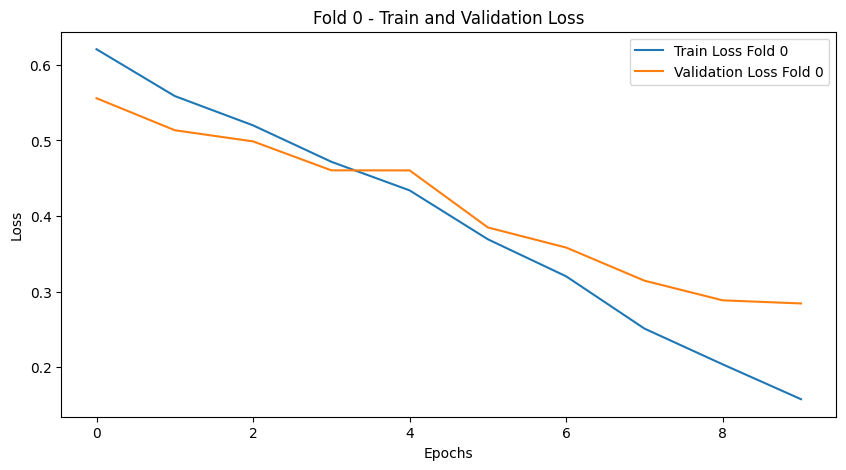

FileNotFoundError: [Errno 2] No such file or directory: 'fold_0_loss_plot.png'

In [17]:
fold_train_losses = []
fold_val_losses = []
num_epochs = 10 

start_time = time.time()
# Start an MLflow run
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("k_folds", k_folds)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_epochs", num_epochs)
    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        train_subsampler = Subset(train_dataset, train_ids)
        val_subsampler = Subset(train_dataset, val_ids)

        train_loader = DataLoader(train_subsampler, batch_size=batch_size, shuffle=True, num_workers=0)
        val_loader = DataLoader(val_subsampler, batch_size=batch_size, shuffle=False, num_workers=0)

        net = Covid19Net()
        net.to(device)

        criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)
        optimizer = optim.SGD(net.parameters(), lr=0.003, momentum=0.9)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            running_train_loss = 0.0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                # Forward pass
                outputs = net(images)
                loss = criterion(outputs, labels)
                running_train_loss += loss.item()

                # Backward pass
                loss.backward()
                optimizer.step()

            train_loss = running_train_loss / len(train_loader)
            train_losses.append(train_loss)

            running_val_loss = 0.0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()

            val_loss = running_val_loss / len(val_loader)
            val_losses.append(val_loss)

            print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')

            mlflow.log_metric(f"train_loss_fold_{fold}", train_loss, step=epoch)
            mlflow.log_metric(f"val_loss_fold_{fold}", val_loss, step=epoch)

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        print('--------------------------------')

    mlflow.pytorch.log_model(net, "model")

end_time = time.time()
execution_time = end_time - start_time


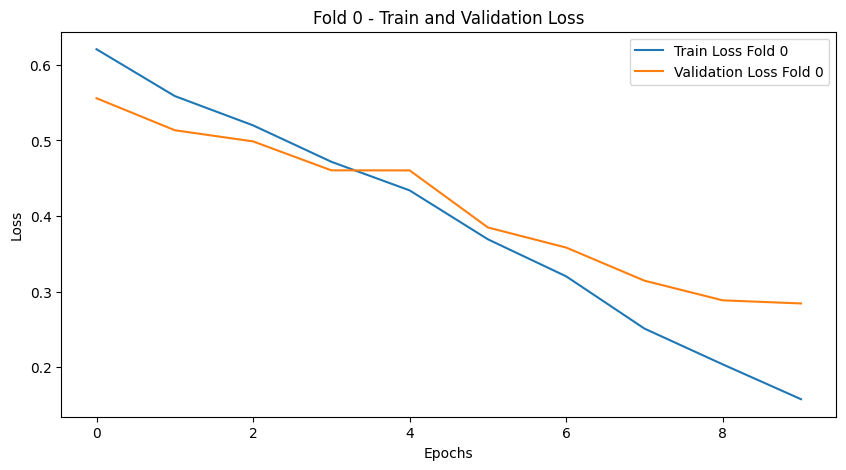

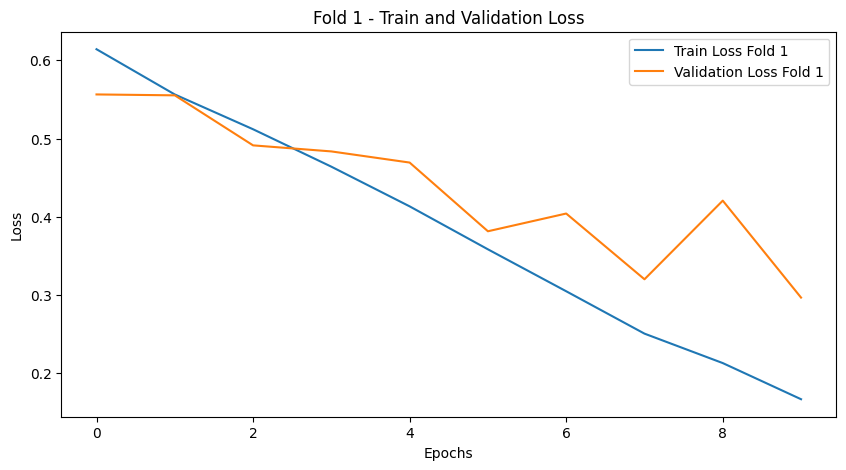

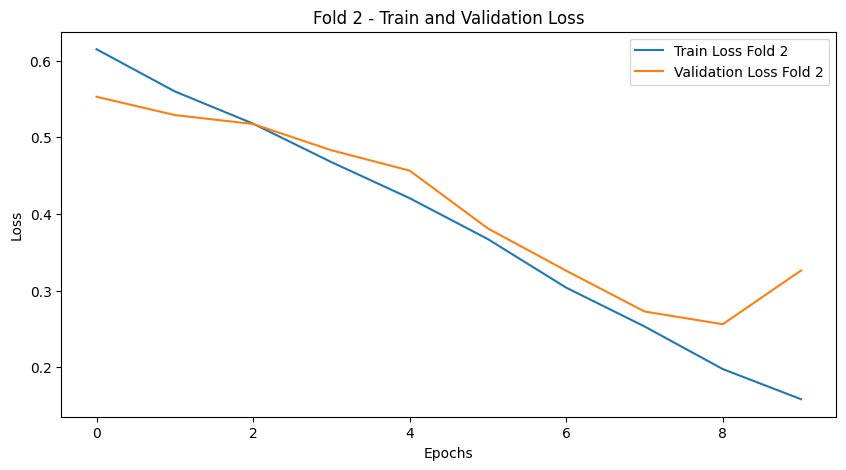

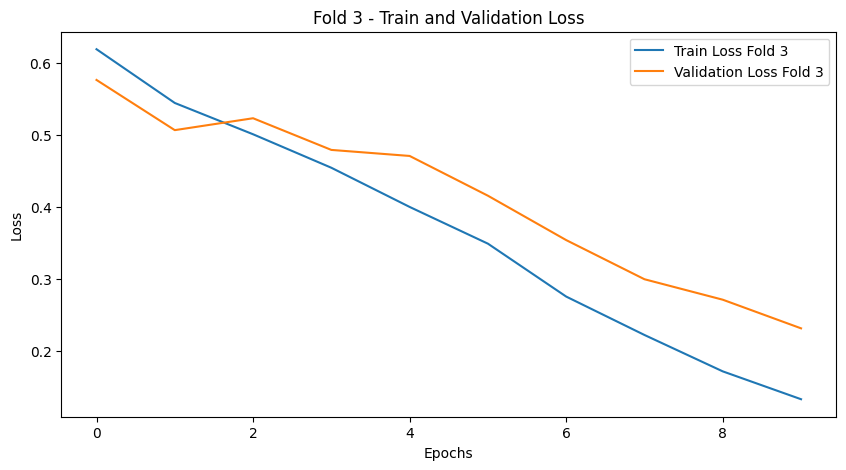

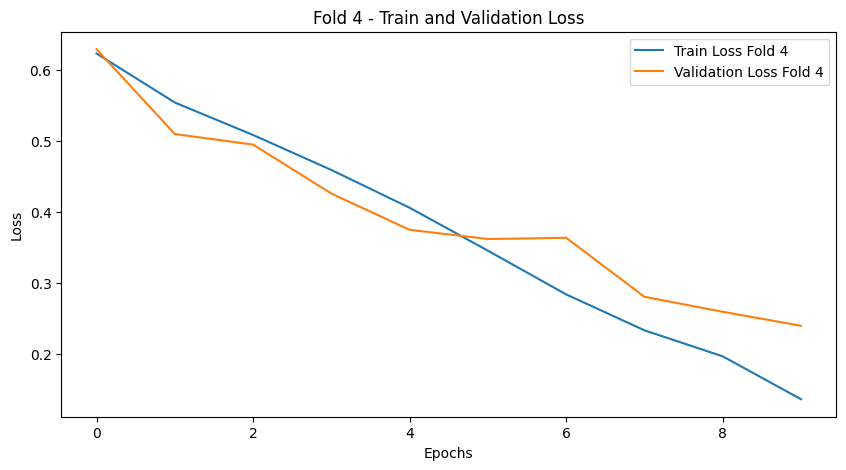

K-FOLD CROSS VALIDATION COMPLETE
--------------------------------


In [20]:

for fold in range(k_folds):
    plt.figure(figsize=(10, 5))
    plt.plot(fold_train_losses[fold], label=f'Train Loss Fold {fold}')
    plt.plot(fold_val_losses[fold], label=f'Validation Loss Fold {fold}')
    plt.title(f'Fold {fold} - Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

torch.save(net.state_dict(), project_path + 'covid19_kfold.pth')

print('K-FOLD CROSS VALIDATION COMPLETE')
print('--------------------------------')

## Evaluate

## ANET - Covid19Net with dropout

Accuracy of the network on the 4849 test images: 99.15 %
Training done on device: cuda
Precision: 99.19
Recall: 99.02
F2 Score: 99.05


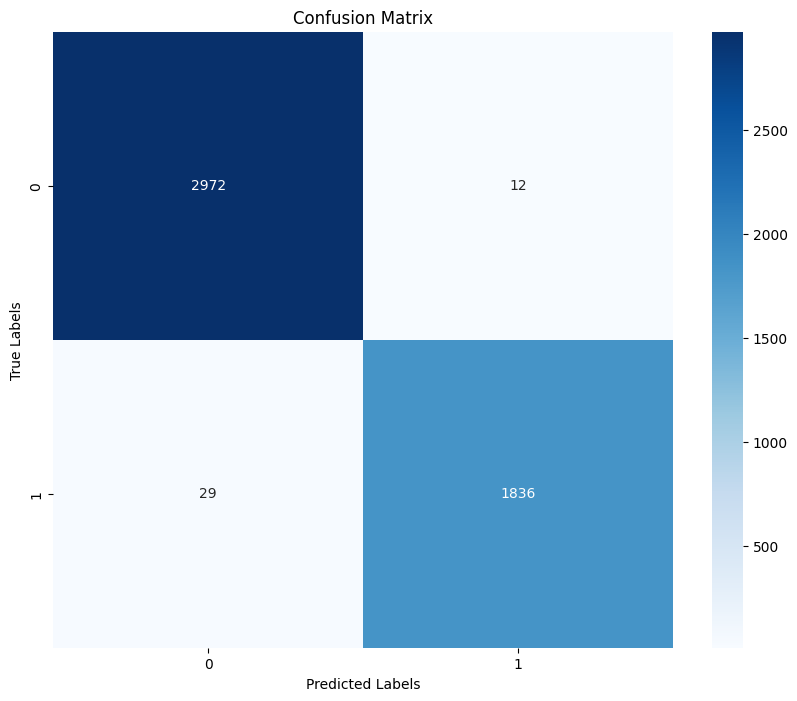

In [6]:
net = ANET()
net.load_state_dict(torch.load(project_path + 'a_net.pth'))

# net = Covid19Net()
# net.load_state_dict(torch.load(project_path + 'covid19_net.pth'))

correct = 0
total = 0
all_labels = []
all_predictions = []
correct_indices = []
incorrect_indices = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            if predicted[i] == labels[i]:
                correct_indices.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
            else:
                incorrect_indices.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))


precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f2_score = fbeta_score(all_labels, all_predictions, beta=2, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)


print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100 * correct / total))
print('Training done on device:', device)

print('Precision: %.2f' % (precision * 100))
print('Recall: %.2f' % (recall * 100))
print('F2 Score: %.2f' % (f2_score * 100))

with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("accuracy", 100 * correct / total)
    mlflow.log_metric("precision", precision * 100)
    mlflow.log_metric("recall", recall * 100)
    mlflow.log_metric("f2_score", f2_score * 100)


    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    confusion_matrix_path = "confusion_matrix.png"
    plt.savefig(confusion_matrix_path)
    plt.show()

## Covid19Net

Accuracy of the network on the 4849 test images: 93.44 %
Training done on device: cuda
Precision: 93.23
Recall: 92.87
F2 Score: 92.94


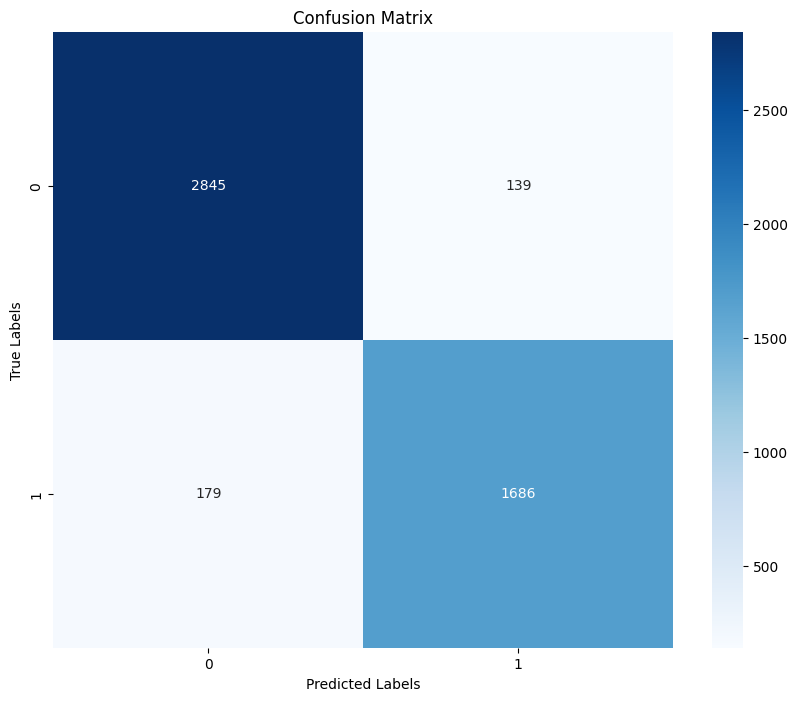

In [21]:
# net = ANET()
# net.load_state_dict(torch.load(project_path + 'a_net.pth'))

net = Covid19Net()
net.load_state_dict(torch.load(project_path + 'covid19_kfold.pth'))

correct = 0
total = 0
all_labels = []
all_predictions = []
correct_indices = []
incorrect_indices = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)   
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

        for i in range(labels.size(0)):
            if predicted[i] == labels[i]:
                correct_indices.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))
            else:
                incorrect_indices.append((images[i].cpu(), predicted[i].cpu(), labels[i].cpu()))


precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f2_score = fbeta_score(all_labels, all_predictions, beta=2, average='macro')
conf_matrix = confusion_matrix(all_labels, all_predictions)


print('Accuracy of the network on the %d test images: %.2f %%' % (total, 100 * correct / total))
print('Training done on device:', device)

print('Precision: %.2f' % (precision * 100))
print('Recall: %.2f' % (recall * 100))
print('F2 Score: %.2f' % (f2_score * 100))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Correct Predictions:


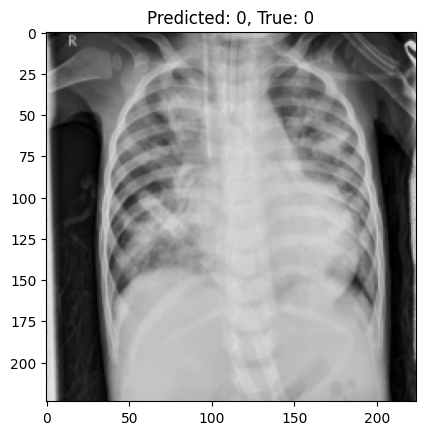

Incorrect Predictions:


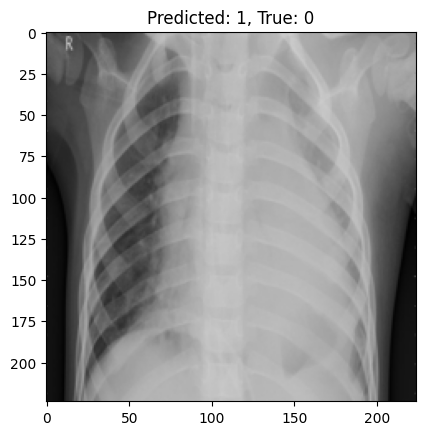

In [21]:
# Plot some correct predictions
print("Correct Predictions:")
for img, pred, true in correct_indices[:1]: 
    imshow(img, title=f"Predicted: {pred}, True: {true}")

# Plot some incorrect predictions
print("Incorrect Predictions:")
for img, pred, true in incorrect_indices[:1]: 
    imshow(img, title=f"Predicted: {pred}, True: {true}")

### 0 = Bacteria, 1 = Viral

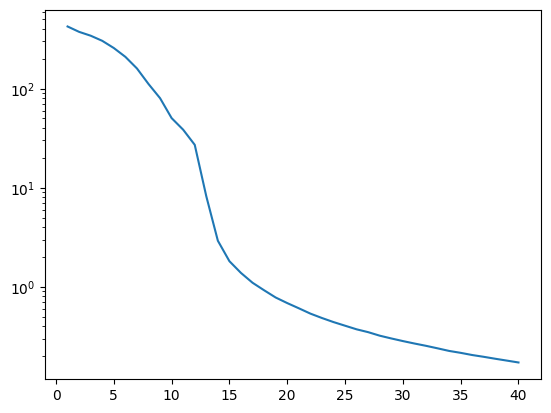

In [8]:

plt.yscale("log")
plt.plot(e_,loss_)
plt.show()


## # Train-Test Size
We re-distribute the train-test split size from 80-20 to 70-30 first, to reduce time in training.
That means from 2 class images we have, 
### 9947 Bacteria and 6221 Viral, we got
### Bacteria Train : 6963, Viral : 4355 = 11318 Train Images
### Bacteria Test : 2984, Viral : 1866 = 4850 Test Images

![images](pneuCLASSreportIMG\covid19net.png)

## # Setting
Start with covid19net from the tutorial to test the workflow

Loss Function = CrossEntropyLoss

Optimizer = Stochastic Gradient Descent

# From the 0
We start simple,


## Epoch = 20, Learning Rate = 0.001
momentum = 0.9

![images](pneuCLASSreportIMG\0_log.png)![images](pneuCLASSreportIMG\0_plt.png)

The loss plot line show shallow slope that is increasing after entering the epoch 13th, which mean we can increase Epoch and learning rate

Accuracy is 99% on test set, which can happen, but with loss this high with CrossEntropyLoss, 
its mean that they maybe outlier that makes the loss value high

*The accuracy on test set is good, but I think we still need to decrease loss further*

## # 1 Increasing Epoch and Learning Rate

#### *We want to see if the loss can continue declining if we increase the epoch to see if its starts to faltten out.*

### Epoch = 40, Learning Rate = 0.0025 

Then, Let's increase epoch to find if the loss slope declines 


![images](pneuCLASSreportIMG\11_log.png)![images](pneuCLASSreportIMG\11_plt.png)


The loss plot still gradually declines but the slope starting to get more shallow, however we increase the epoch number to see if its flattening

## # 1.1 

## Epoch = 40 Learning Rate = 0.003

![images](pneuCLASSreportIMG\11_plt2.png)

~ 50 minutes
![images](pneuCLASSreportIMG\13_log.png)![images](pneuCLASSreportIMG\13_plt.png)


## # 1.2
Increasing epoch and learning rate to find where the model stops learning
### Epoch = 60, Learning Rate = 0.003


Even after increasing the epoch to 60, the graph still continue declining

~75 minutes

![images](pneuCLASSreportIMG\12_log.png)![images](pneuCLASSreportIMG\12_plt.png)

After try increasing more learning rate (0.0035), the loss starts exploding.

![images](pneuCLASSreportIMG\conf_Cov19Net.png)

## # 2 - Add Batch Normalization, Drop Out
The model overfit or not? Let's regularize it by
Normalize input of each layer, Dropout some neurons.
### Epoch = 40, Learning Rate = 0.0025

trying batch normalization, the loss bouncing up and down. and explode around 40 epoch, However, the loss never goes under 1.

BatchNormalization may impact the scale on each layer input, which making the model have difficulties in learning the important features.

![images](pneuCLASSreportIMG\21_log.png)![images](pneuCLASSreportIMG\21_plt.png)

Using Dropout probability at 0.1 before every activation in both layer.
Performance is better than using BatchNormalization, model have instability in learning, the loss goes up in some epoch.

![images](pneuCLASSreportIMG\22_log.png)![images](pneuCLASSreportIMG\22_plt.png)

![images](pneuCLASSreportIMG\conf_Anet.png)

## # 3 - Add layer 3

No dropout, batchnormalization

Add third layer into the neural network input size[3, 16, 32]
### Epoch = 40, Learning rate = 0.0025
First loss gradually decrease.
But there is come jiggering in loss value below 1

![images](pneuCLASSreportIMG\lr001ep40tt7030_3layer.png)
![images](pneuCLASSreportIMG\lr001ep40tt7030lossplot_3layer.png)

# 4 Weighted Class loss




![images](pneuCLASSreportIMG\4_log.png)
![images](pneuCLASSreportIMG\4_plt.png)
![images](pneuCLASSreportIMG\4_plt2.png)